In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np

In [6]:
audio, Sam_rate = librosa.load('speech_noise.wav')
print(f'audio : {audio} , Sampling Rate: {Sam_rate}, Shape = {audio.shape} ')

audio : [ 0.05032349  0.02615356 -0.05487061 ... -0.09442139 -0.13113403
 -0.10925293] , Sampling Rate: 22050, Shape = (110250,) 


In [7]:
ipd.Audio('speech_noise.wav')

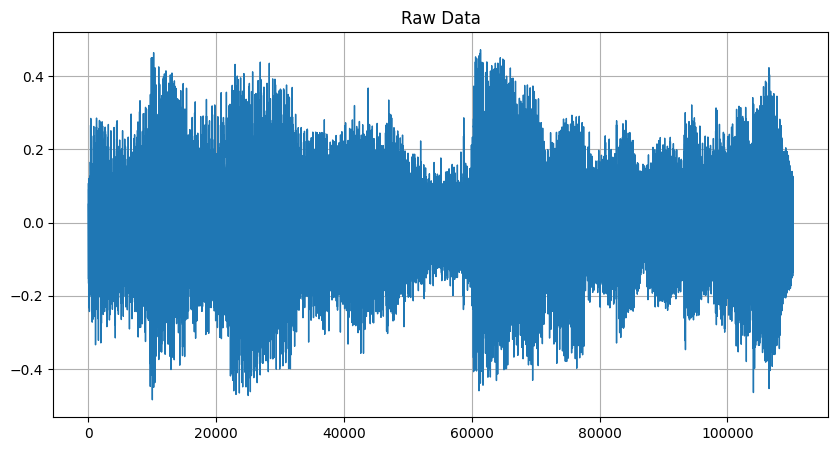

In [8]:
pd.Series(audio).plot(figsize =(10,5), lw =1, title = 'Raw Data')
plt.grid('True')
plt.show()

In [9]:
def derivative_sound(sig):
  sig = [0] + list(sig)
  y = []
  for i in range(1, len(sig)):
    y = y + [sig[i]- sig[i-1]]
  return np.array(y)

audio2 = derivative_sound(audio)

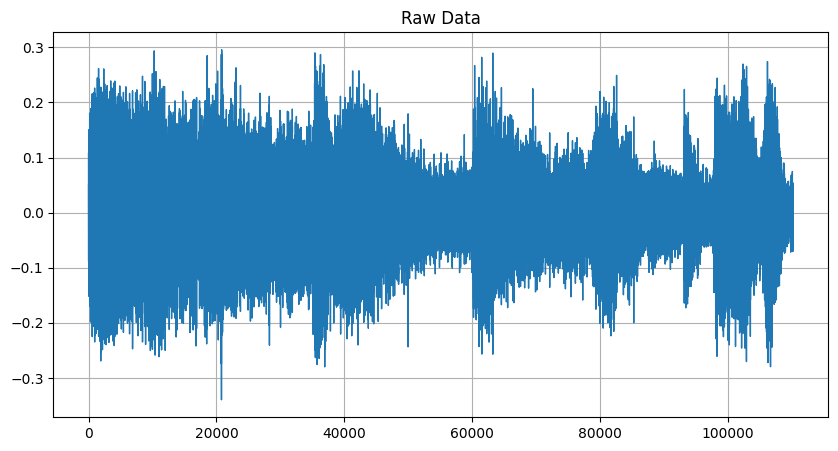

In [10]:
pd.Series(audio2).plot(figsize =(10,5), lw =1, title = 'Raw Data')
plt.grid('True')
plt.show()

In [11]:
def find_threshold(sig):
  return 0.7*max(sig[1:1344])

th = find_threshold(audio)
th

0.200079345703125

In [12]:
window = 20*Sam_rate//1000 #20 msec
window = 2*(window//2)
window

440

In [13]:
## padding function
def padSignal(a,size):
  temp = [0 for i in range(size//2)]
  temp = temp + list(a) + temp
  return np.array(temp)

In [14]:
def short_time_rms (y, window):
  x = padSignal(y,window)
  y2 = []

  for i in range(window + len(x)-1):
    y2.append(np.sqrt((sum(x[i:i+window]**2))/(window)))
  return y2


In [15]:
rms_sig = short_time_rms(audio, window)
rms_sig_der = short_time_rms(audio2, window)

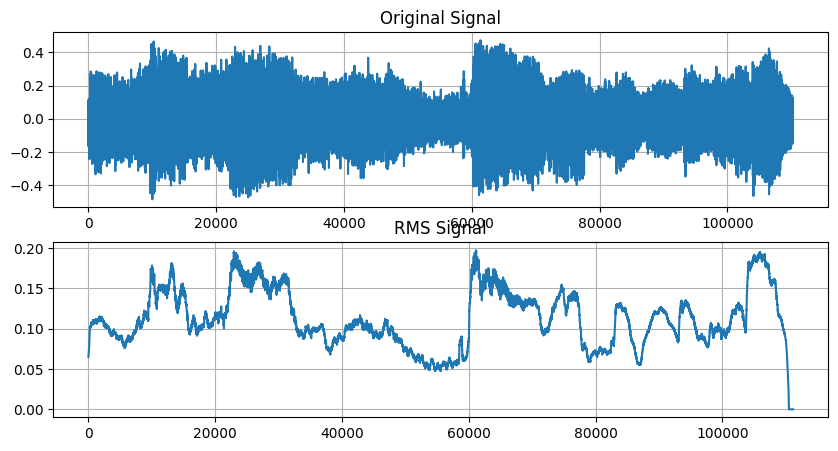

In [16]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,5))
ax1.plot(audio)
ax1.set_title('Original Signal')
ax1.grid()

ax2.plot(rms_sig)
ax2.set_title('RMS Signal')
ax2.grid()
plt.show()

In [17]:
def tunscount_phase1(sig):
  x = list(sig)
  x = [0] + x + [0]
  count = 0
  y = []
  for i in range(2, len(x)-1):
    if (((x[i] - x[i-1]) * (x[i+1] - x[i])) <0):
      count+= 1
      y = y+ [i]
  return y



In [18]:
tc_phase1 = np.array(tunscount_phase1(audio))

In [19]:
tc_phase1_der = np.array(tunscount_phase1(audio2))

In [20]:
def tunscount_phase2(sig, tc, th):
  x = [0] + list(sig) + [0]
  count = 0
  y = []
  for i in range(2, len(tc)-1):
    turn1 = np.abs(x[tc[i-1]] - x[tc[i]])
    turn2 = np.abs(x[tc[i]] - x[tc[i+1]])
    if ((turn1> th) & (turn2 >th)):
      count+= 1
      y = y+ [tc[i]]
  return y



In [21]:
tc_phase2 = np.array(tunscount_phase2(audio, tc_phase1, th))

In [22]:
tc_phase2_der = np.array(tunscount_phase2(audio2, tc_phase1_der, th))

In [23]:
def turns_count(l, window, tc_p):
  l = l + window
  x = np.zeros(l)
  count = 0
  for i in range(l):
    if (i == tc_p[count]):
      x[i]= 1
      if (count < len(tc_p)-1):
            count+=1

  y2 = []
  s=0

  for i in range(len(x) - window):
   s = np.sum(x[i:i+window])
   y2 = y2 + [s]
  return np.array(y2)

In [24]:
audio_tc = turns_count(len(audio), window, tc_phase2)

In [25]:
audio_tc_der = turns_count(len(audio2), window, tc_phase2_der)

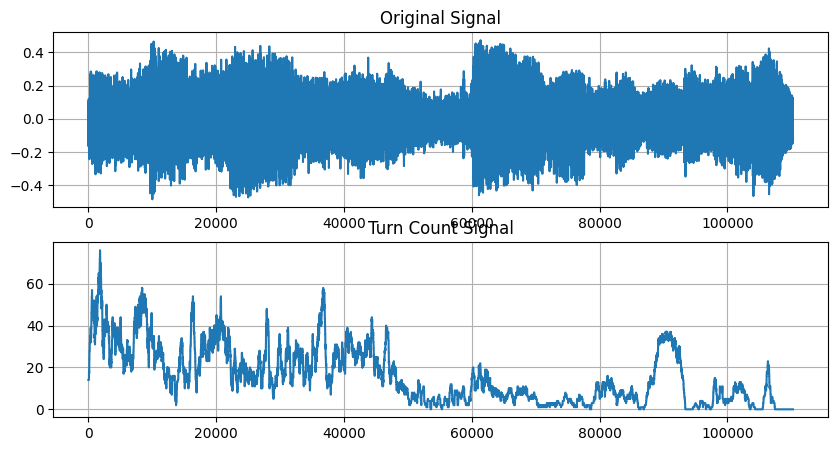

In [26]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize= (10,5))
ax1.plot(audio)
ax1.set_title('Original Signal')
ax1.grid()

ax2.plot(audio_tc)
ax2.set_title('Turn Count Signal')
ax2.grid()
plt.show()

In [27]:
def find_zero (sig):
  count = 0;
  for i in range(len(sig)-1):
    if (sig[i]*sig[i+1]<= 0):
      count +=1

  return count

In [28]:
def zero_count(sig, win):
  n1 = np.ones(win//2)
  x = list(n1) + list(sig) + list(n1)
  y = []

  for i in range(len(x)-win):
    y1 = find_zero(x[i:i+window])
    y = y+ [y1]

  return np.array(y)


In [29]:
zero_cs = zero_count(audio, window)

In [30]:
zero_cs_der = zero_count(audio2, window)

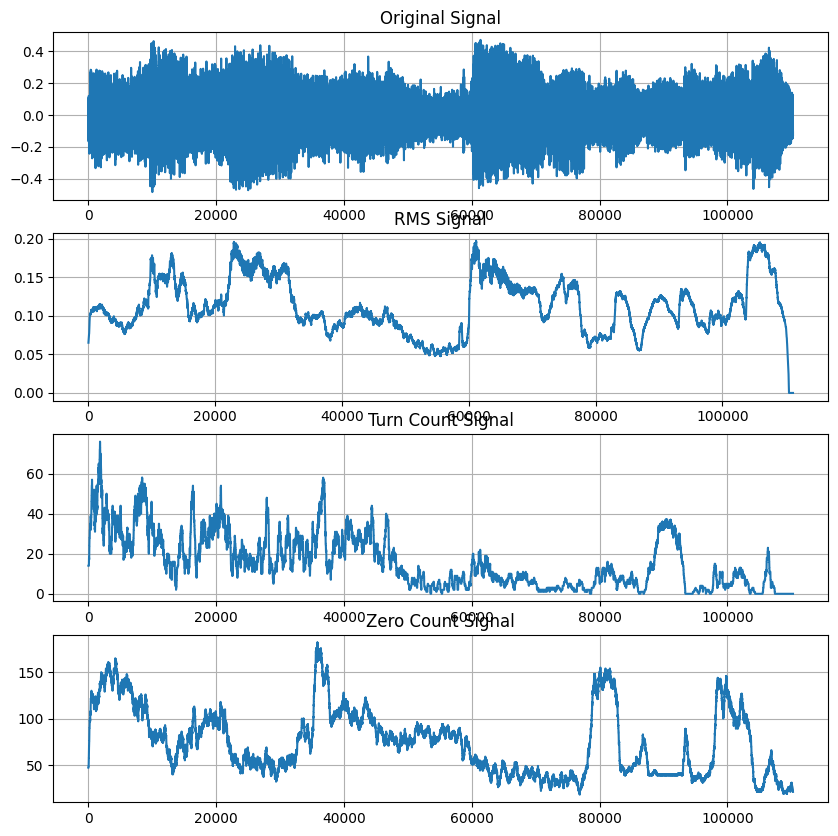

In [31]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,10))
ax1.plot(audio)
ax1.set_title('Original Signal')
ax1.grid()

ax2.plot(rms_sig)
ax2.set_title('RMS Signal')
ax2.grid()


ax3.plot(audio_tc)
ax3.set_title('Turn Count Signal')
ax3.grid()


ax4.plot(zero_cs)
ax4.set_title('Zero Count Signal')
ax4.grid()
plt.show()

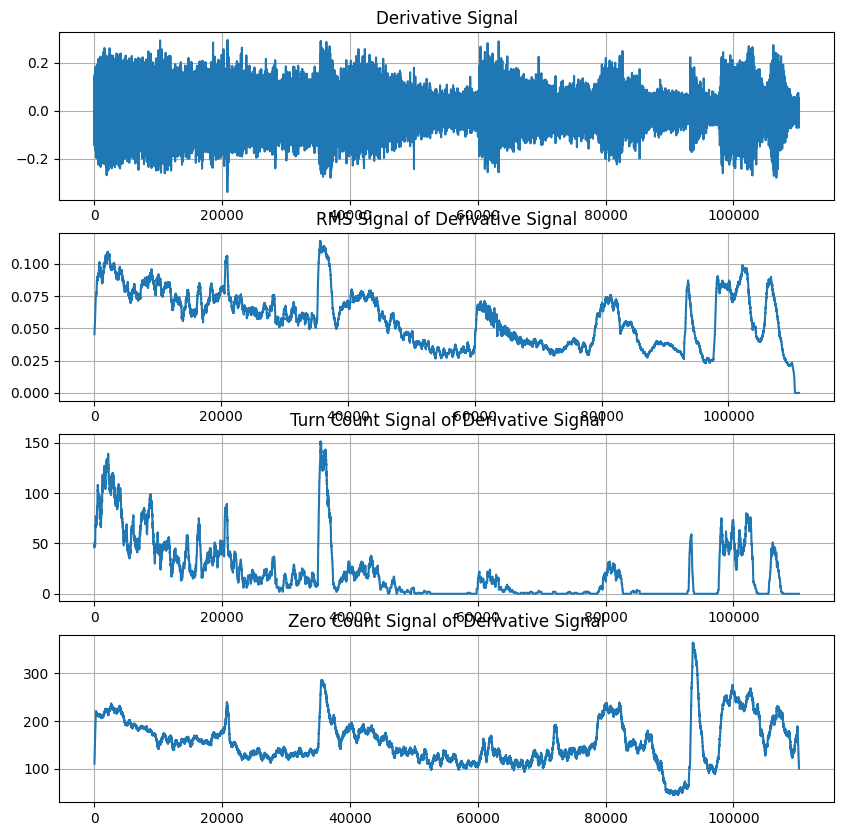

In [32]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,10))
ax1.plot(audio2)
ax1.set_title('Derivative Signal')
ax1.grid()

ax2.plot(rms_sig_der)
ax2.set_title('RMS Signal of Derivative Signal')
ax2.grid()


ax3.plot(audio_tc_der)
ax3.set_title('Turn Count Signal of Derivative Signal')
ax3.grid()


ax4.plot(zero_cs_der)
ax4.set_title('Zero Count Signal of Derivative Signal')
ax4.grid()
plt.show()

In [33]:
def segment_voice (rms, zc, sig):
  y = []
  for i in range(len(zc)):
    if ((rms[i]>0.04) & (zc[i]<40)):
      y = y + [sig[i]]
    else:
      y = y+ [0]
  return np.array(y)

In [34]:
def segment_unvoice (rms, zc, sig, tc):
  y = []
  for i in range(len(zc)):
    if ((rms[i]<0.06) & (zc[i]>8) & (tc[i]>4)):
      y = y + [sig[i]]
    else:
      y = y+ [0]
  return np.array(y)

In [35]:
def silence(v, uv, aud):
  y = []
  for i in range(len(v)):
    if ((v[i]==0) & (uv[i]==0)):
      y = y + [aud[i]]
  return np.array(y)

In [36]:
voiced = segment_voice (rms_sig, zero_cs, audio)
unvoiced = segment_unvoice (rms_sig, zero_cs, audio, audio_tc)


In [37]:
sil = silence(voiced, unvoiced, audio)

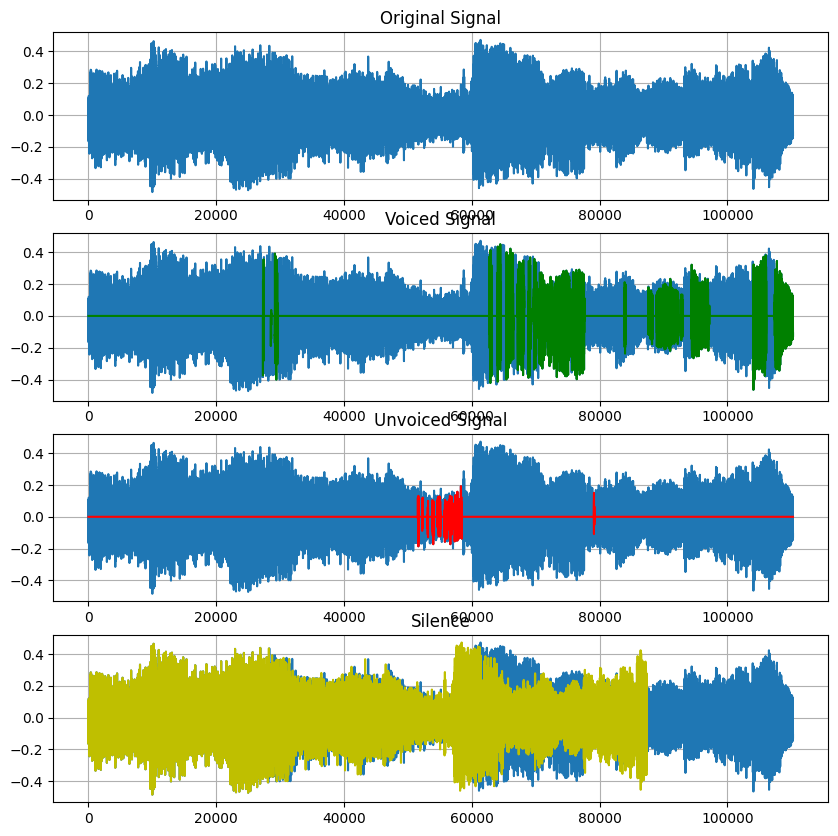

In [38]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize= (10,10))
ax1.plot(audio)
ax1.set_title('Original Signal')
ax1.grid()

ax2.plot(audio)
ax2.plot(voiced, 'g')
ax2.set_title('Voiced Signal')
ax2.grid()

ax3.plot(audio)
ax3.plot(unvoiced, 'r')
ax3.set_title('Unvoiced Signal')
ax3.grid()

ax4.plot(audio )
ax4.plot(sil, 'y')
ax4.set_title('Silence')
ax4.grid()
plt.show()

In [39]:
!pip install spectrum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from spectrum import *
from pylab import *

def AR_model(data, order):
  ar, P, k = aryule(data, order, norm='biased')
  psd = arma2psd(ar)
  # Get just one side of the psd
  Pxx = psd[len(psd):len(psd) // 2:-1]
  Pxx =np.abs(Pxx)**2
  plot(Pxx)

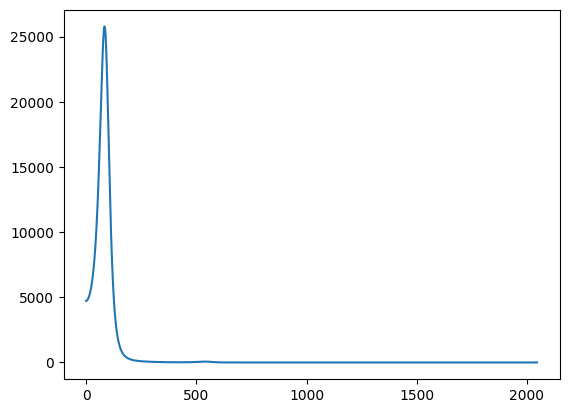

In [45]:
AR_model(voiced, 16)

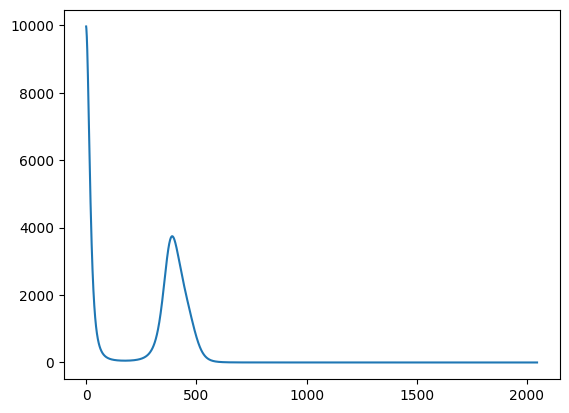

In [46]:
AR_model(unvoiced, 16)

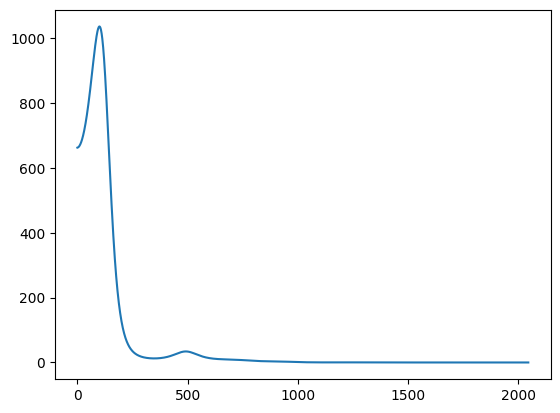

In [47]:
AR_model(sil, 16)

In [48]:
def fft_psd(x,fs):
  nfft = len(x)
  psd = np.abs(np.fft.fft(x, n=nfft))**2 / (fs * nfft)

  # Plot the PSD
  freqs = np.fft.fftfreq(nfft, d=1/fs)
  plt.plot(freqs[:nfft//2], psd[:nfft//2])
  plt.xlabel('Frequency (Hz)')
  plt.ylabel('PSD')
  plt.show()

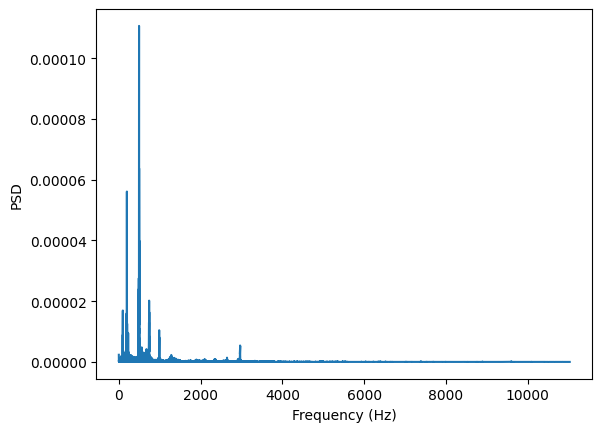

In [49]:
fft_psd(voiced, 22050)

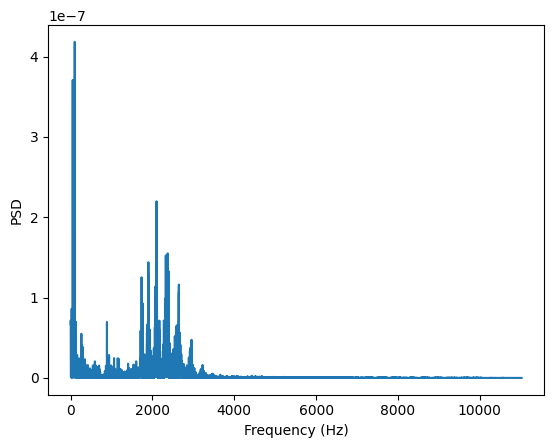

In [50]:
fft_psd(unvoiced, 22050)

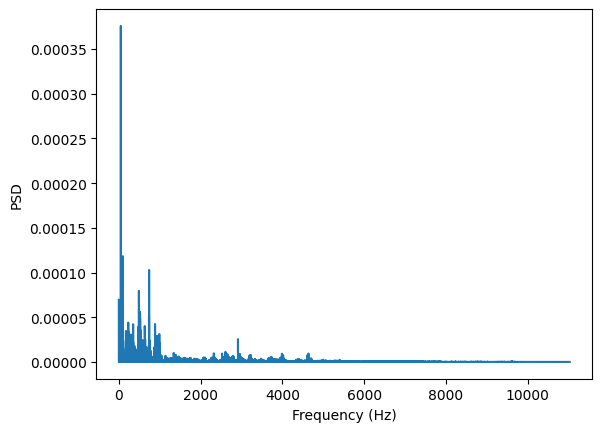

In [51]:
fft_psd(sil, 22050)

In [61]:
import numpy as np
import statsmodels.api as sm

def AR_poles(data):
  # Define the AR coefficients
  ar_coeffs = np.array(data)

  # Create an AR model
  ar_model = sm.tsa.AutoReg(np.zeros(100), lags = 0)
  ar_model.arparams = -ar_coeffs[1:]

  # Get the AR model poles
  ar_poles = ar_model.arroots

  print("AR poles:", ar_poles)

In [63]:
from statsmodels.tsa.api import AutoReg


def AR_poles2(data):
  # Create some sample data
  np.random.seed(0)

  # Fit an ARMA(1,1) model to the data
  model = AutoReg(data, lags=1)
  results = model.fit()

  # Print the model summary
  print(results.summary())

In [65]:
AR_poles2(voiced)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:               110250
Model:                     AutoReg(1)   Log Likelihood              274377.615
Method:               Conditional MLE   S.D. of innovations              0.020
Date:                Wed, 12 Apr 2023   AIC                        -548749.230
Time:                        12:18:27   BIC                        -548720.398
Sample:                             1   HQIC                       -548740.518
                               110250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.547e-05   6.05e-05     -0.751      0.452      -0.000    7.31e-05
y.L1           0.9351      0.001    876.193      0.000       0.933       0.937
                                    Roots           

In [66]:
AR_poles2(unvoiced)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:               110250
Model:                     AutoReg(1)   Log Likelihood              436698.057
Method:               Conditional MLE   S.D. of innovations              0.005
Date:                Wed, 12 Apr 2023   AIC                        -873390.114
Time:                        12:19:25   BIC                        -873361.283
Sample:                             1   HQIC                       -873381.403
                               110250                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.928e-05   1.39e-05     -1.389      0.165   -4.65e-05    7.93e-06
y.L1           0.8335      0.002    500.846      0.000       0.830       0.837
                                    Roots           

In [67]:
AR_poles2(sil)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                87348
Model:                     AutoReg(1)   Log Likelihood              113475.144
Method:               Conditional MLE   S.D. of innovations              0.066
Date:                Wed, 12 Apr 2023   AIC                        -226944.288
Time:                        12:19:44   BIC                        -226916.155
Sample:                             1   HQIC                       -226935.698
                                87348                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0007      0.000     -3.300      0.001      -0.001      -0.000
y.L1           0.8244      0.002    430.499      0.000       0.821       0.828
                                    Roots           